In [157]:
using Revise
using RCall

## Detectability Curves

Let's compute detectability curves for the binary clustering task. We'll use the formula, which I *think* is correct, for the leading eigenvalue of $\mathbf{G}$:

$$\eta = \frac{1}{\ell - 1} \frac{c_k^i - (k-1)c_k}{(k-1)c_k}$$

We'll also need the formula (which I *think* is correct, but would definitely be at best a conjecture regardless) for the 2nd eigenvalue of $\mathbf{B}_k$, 

$$\lambda_2 = \frac{c_k^i - c_k^o}{2} = \frac{c_k^i - (k-1)c_k}{2(1-q)}$$

This yields, as our estimate for the relevant eigenvalue of the BP Jacobian, assuming parallel eigenvectors, 

$$ \gamma = \frac{\ell}{2(\ell - 1)^2}\sum_k \frac{(c_k^i - (k-1)c_k)^2}{(k-1)c_k}$$ 

We also need to express $c_k^i$ in terms of $p_k$ in order to plot this. 
We have 

$$ c_k^i = \frac{k-1}{q}\left(p_k + (1-p_k)q\frac{1 - q^{k-2}}{1 - q^{k-1}}\right) c_k$$

## Ellipsoid parameters

The coordinate of the centroid of the ellipsoid corresponding to edges of size $k$ is: 

$$a_k = \frac{q - r_k}{1 - r_k}\;,$$

where $r_k = q\frac{1 - q^{k-2}}{1-q^{k-1}}$.

The radius of the ellipsoid corresponding to edges of size $k$ is 
$$$$

Before we try to get too wild with coding this up, maybe we should start just by plotting some level curves. 

In [158]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 3

C₁ = 5
C₂ = 5

R"""

library(tidyverse)
library(ggforce)

compute_c <- function(p, k, l, C){
    q <- 1/l
    (k-1)/q * (p + (1-p)*q*(1-q^(k-2))/(1-q^(k-1)))*C
}
compute_term <- function(p, k, l, C){
    c_i <- compute_c(p, k, l, C)
    l / (2*(l - 1)^2) * ((c_i - (k-1)*C)^2)/((k-1)*C)
}

compute_term_2 <- function(p, k, l, C){
    c_i <- compute_c(p, k, l, C)
    1 / (l - 1) * (c_i - (k-1)*C)
}


compute_primary_centroid <- function(k, l){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))
    -(r - q)/ (1 - r)
}

compute_primary_radius <- function(k, l, C){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))
    sqrt(2*(l-1)^2/l * q^2/((k-1)*C)*(1/(1-r)^2))
}
compute_primary_ellipse <- function(k_1, k_2, l, C_1, C_2){
    tibble(theta = seq(0, 2*pi, 0.001)) %>% 
    mutate(x = compute_primary_radius(k_1, l, C_1)*cos(theta) + compute_primary_centroid(k_1, l),
           y = compute_primary_radius(k_2, l, C_2)*sin(theta) + compute_primary_centroid(k_2, l)) %>% 
    arrange(desc(theta))
}

"""



RObject{ClosSxp}
function (k_1, k_2, l, C_1, C_2) 
{
    tibble(theta = seq(0, 2 * pi, 0.001)) %>% mutate(x = compute_primary_radius(k_1, 
        l, C_1) * cos(theta) + compute_primary_centroid(k_1, 
        l), y = compute_primary_radius(k_2, l, C_2) * sin(theta) + 
        compute_primary_centroid(k_2, l)) %>% arrange(desc(theta))
}


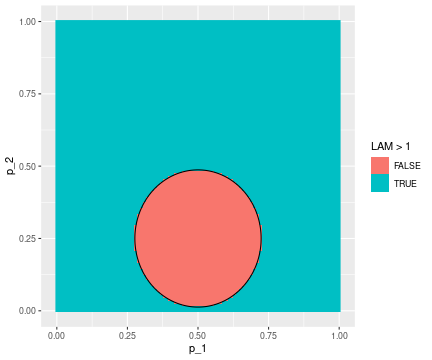

RObject{VecSxp}


In [159]:
R"""

df <- expand.grid(p_1 = seq(0, 1, 0.01), p_2 = seq(0, 1, 0.01)) %>% 
    tibble() %>% 
    mutate(t_1 = compute_term(p_1, k = $k₁, l = $ℓ, C = $C₁), 
           t_2 = compute_term(p_2, k = $k₂, l = $ℓ, C = $C₂),
           m_1 = compute_term_2(p_1, k = $k₁, l = $ℓ, C = $C₁), 
           m_2 = compute_term_2(p_2, k = $k₂, l = $ℓ, C = $C₂),
           LAM = t_1 + t_2,
           MU = m_1 + m_2) 

ellipse <- compute_primary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)



df %>%   
    ggplot() + 
    geom_raster(aes(x = p_1, y = p_2, fill = LAM > 1)) + 
    geom_path(aes(x = x, y = y), data = ellipse)

"""

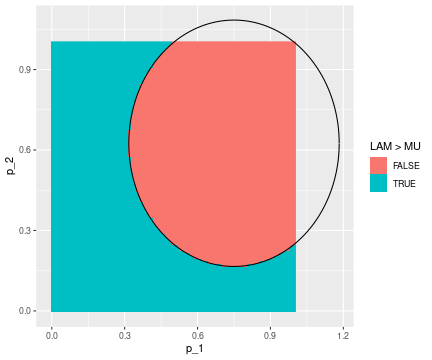

RObject{VecSxp}


In [160]:
R"""

compute_secondary_centroid <- function(k, l, C){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))

    a <- l/((2*(l-1)^2)*((k-1)*C))
    b <- -1/(l-1)
    y <- (k-1)*C/q*(1-r)
    z <- -(k-1)*C*(r/q - 1)
    z/y - b/(2*a*y)
}

compute_secondary_radius <- function(k, l, C, m){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))
    a <- l/((2*(l-1)^2)*((k-1)*C))
    y <- (k-1)*C/q*(1-r)
    sqrt(m/(a*y^2))
}

compute_m <- function(k_1, k_2, l, C_1, C_2){
    a_1 <- l/((2*(l-1)^2)*((k_1-1)*C_1))
    a_2 <- l/((2*(l-1)^2)*((k_2-1)*C_2))
    b   <- -1/(l-1)
    1/4*b^2*(1/a_1 + 1/a_2)
}

compute_secondary_ellipse <- function(k_1, k_2, l, C_1, C_2){
    tibble(theta = seq(0, 2*pi, 0.01)) %>% 
    mutate(m = compute_m(k_1, k_2, l, C_1, C_2),
           x = compute_secondary_radius(k_1, l, C_1, m)*cos(theta) + compute_secondary_centroid(k_1, l, C_1),
           y = compute_secondary_radius(k_2, l, C_2, m)*sin(theta) + compute_secondary_centroid(k_2, l, C_2)) %>% 
    arrange(desc(theta))
}

ellipse <- compute_secondary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂) 

df %>% 
    ggplot() + 
    geom_raster(aes(x = p_1, y = p_2, fill = LAM > MU)) + 
    geom_path(aes(x = x, y = y), data = ellipse)
"""

In [161]:
R"""
library(tidyverse)
library(viridis)
"""

RObject{StrSxp}
 [1] "patchwork"   "viridis"     "viridisLite" "ggforce"     "forcats"    
 [6] "stringr"     "dplyr"       "purrr"       "readr"       "tidyr"      
[11] "tibble"      "ggplot2"     "tidyverse"   "stats"       "graphics"   
[16] "grDevices"   "utils"       "datasets"    "methods"     "base"       


In [162]:
R"""
df <- read_csv("throughput/bulk-throughput/exp-1.csv")
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   P_4 = col_double(),
│   C_2 = col_double(),
│   C_3 = col_double(),
│   C_4 = col_double(),
│   N_1 = col_double(),
│   N_2 = col_double(),
│   ARI = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
# A tibble: 198,957 x 9
     P_2   P_3   P_4   C_2   C_3   C_4   N_1   N_2   ARI
   <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1     0  0        0     5     5     0   100   100 0.980
 2     0  0.01     0     5     5     0   100   100 1    
 3     0  0.02     0     5     5     0   100   100 1    
 4     0  0.03     0     5     5     0   100   100 0.980
 5     0  0.04     0     5     5     0   100   100 1    
 6     0  0.05     0     5     5     0   100   100 1    
 7     0  0.06     0     5     5     0   100   100 1    
 8     0  0.07     0     5     5     0   100   100 0.960
 9     0  0.08     0     5     5     0   100   100 0.980
10     0  0.09     0     5     5     0   100   100 1    
# … with 198,947 more rows


┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   P_4 = col_double(),
│   C_2 = col_double(),
│   C_3 = col_double(),
│   C_4 = col_double(),
│   N_1 = col_double(),
│   N_2 = col_double(),
│   ARI = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


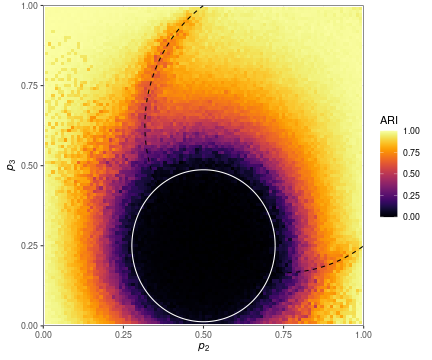

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [203]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 3

C₁ = 5
C₂ = 5

title = "list(italic(c)[$k₁]==$C₁, italic(c)[$k₂]==$C₂)"

R"""

ellipse <- compute_primary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)
secondary_ellipse <- compute_secondary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)

df <- read_csv("throughput/bulk-throughput/exp-1.csv")

df <- df %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

q1 <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = ARI)) + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value="black") + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[3])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() 
# + 
#    ggtitle(parse(text = $title))

p1 <- q1 + 
    geom_path(aes(x = x, y = y), data = secondary_ellipse,  linetype = "dashed") + 
    geom_path(aes(x = x, y = y), data = ellipse, color = "white") 

ggsave("fig/heatmap-exp-1-no-curve.png", q1, dpi = 600, width = 5, height = 4)
ggsave("fig/heatmap-exp-1.png", p1, dpi = 600, width = 5, height = 4)
p1
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   P_4 = col_double(),
│   C_2 = col_double(),
│   C_3 = col_double(),
│   C_4 = col_double(),
│   N_1 = col_double(),
│   N_2 = col_double(),
│   ARI = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


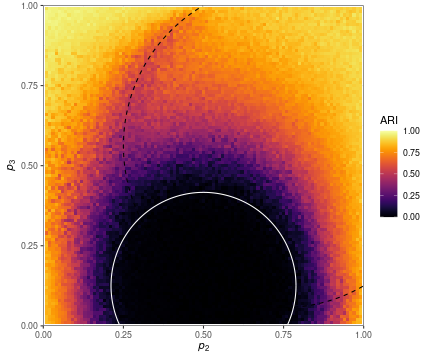

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [204]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 4

C₁ = 3
C₂ = 3

title = "list(italic(c)[$k₁]==$C₁, italic(c)[$k₂]==$C₂)"
R"""

ellipse <- compute_primary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)
secondary_ellipse <- compute_secondary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)


df <- read_csv("throughput/bulk-throughput/exp-2.csv")

df <- df %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

p2 <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_4, fill = ARI)) + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value="black") + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[3])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() + 
    geom_path(aes(x = x, y = y), data = secondary_ellipse,  linetype = "dashed") + 
    geom_path(aes(x = x, y = y), data = ellipse, color = "white") 

# + 
#    ggtitle(parse(text = $title))

ggsave("fig/heatmap-exp-2.png", p2, dpi = 300, width = 5, height = 4)
p2
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   P_4 = col_double(),
│   C_2 = col_double(),
│   C_3 = col_double(),
│   C_4 = col_double(),
│   N_1 = col_double(),
│   N_2 = col_double(),
│   ARI = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


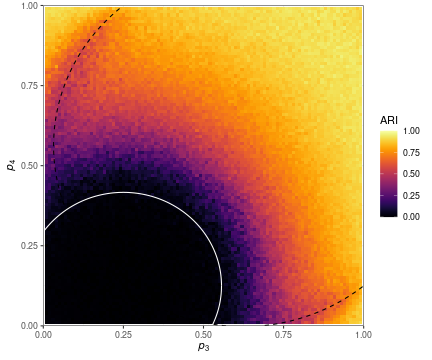

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [205]:
ℓ = 2
q = 1/ℓ

k₁ = 3
k₂ = 4

C₁ = 3
C₂ = 3


title = "list(italic(c)[$k₁]==$C₁, italic(c)[$k₂]==$C₂)"

R"""

ellipse <- compute_primary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)
secondary_ellipse <- compute_secondary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)


df <- read_csv("throughput/bulk-throughput/exp-3.csv")

df <- df %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

p3 <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_3, y = P_4, fill = ARI)) + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value="black") + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(italic(p)[3])) + 
    ylab(expression(italic(p)[4])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() + 
    geom_path(aes(x = x, y = y), data = secondary_ellipse,  linetype = "dashed") + 
    geom_path(aes(x = x, y = y), data = ellipse, color = "white")
# + 
#    ggtitle(parse(text = $title))

ggsave("fig/heatmap-exp-3.png", p3, dpi = 300, width = 5, height = 4)
p3
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   P_4 = col_double(),
│   C_2 = col_double(),
│   C_3 = col_double(),
│   C_4 = col_double(),
│   N_1 = col_double(),
│   N_2 = col_double(),
│   ARI = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


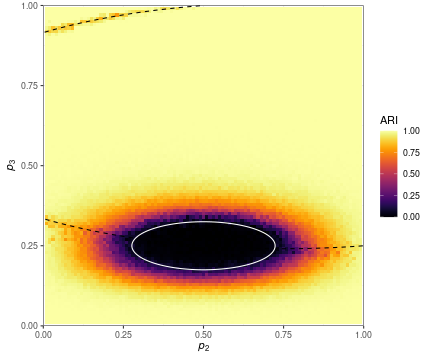

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [206]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 3

C₁ = 5
C₂ = 50

title = "list(italic(c)[$k₁]==$C₁, italic(c)[$k₂]==$C₂)"

R"""

ellipse <- compute_primary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)
secondary_ellipse <- compute_secondary_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)


df <- read_csv("throughput/bulk-throughput/exp-4.csv")

df <- df %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

p4 <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = ARI)) + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value="black") + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[3])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() + 
    geom_path(aes(x = x, y = y), data = secondary_ellipse,  linetype = "dashed") + 
    geom_path(aes(x = x, y = y), data = ellipse, color = "white")
# + 
#    ggtitle(parse(text = $title))

p4
"""

┌ Warning: RCall.jl: Saving 7 x 6 in image
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


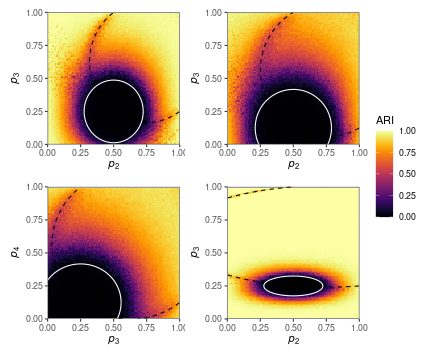

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [207]:
R"""
library(patchwork)
q <- (p1 + p2) / (p3 + p4) + plot_layout(guides = 'collect')

ggsave("fig/4-heatmaps.png",q , dpi = 300, height = 6)
q
"""

┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


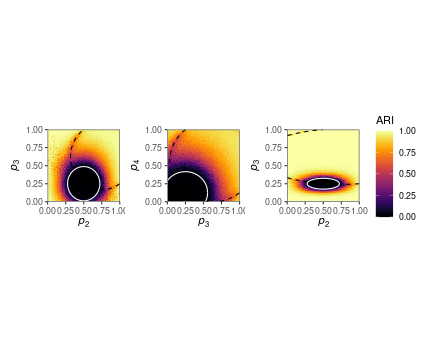

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [208]:
R"""
library(patchwork)
q <- p1 + p3 + p4 + plot_layout(guides = 'collect')

ggsave("fig/3-heatmaps.png",q , dpi = 300, height = 4, width = 10)
q
"""

In [209]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 4

C₁ = 50
C₂ = 5

R"""

ellipse <- compute_ellipse($k₁, $k₂, $ℓ, $C₁, $C₂)

df <- read_csv("throughput/bulk-throughput/exp-5.csv")

df <- df %>%
    group_by(P_2, P_3, P_4) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

p5 <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_4, fill = ARI)) + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value="black") + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[4])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    coord_fixed() + 
    geom_path(aes(x = x, y = y), data = ellipse, color = "white")

ggsave("fig/p5.png",p5 , dpi = 300, height = 3, width = 4)
p5

"""

RCall.REvalError: REvalError: Error: Problem with `mutate()` input `x`.
✖ argument "m" is missing, with no default
ℹ Input `x` is `+...`.
Backtrace:
    █
 1. ├─global::compute_ellipse(...)
 2. │ └─`%>%`(...)
 3. ├─dplyr::arrange(., desc(theta))
 4. ├─dplyr::mutate(...)
 5. └─dplyr:::mutate.data.frame(...)
 6.   └─dplyr:::mutate_cols(.data, ...)
<parent: error/simpleError>
Backtrace:
█

# Vanilla version

Here our aim is to approximate the straight lines on the heatmap for nonbacktracking spectral detection without the use of the nonbacktracking Jacobian. 

Our assumption/conjectures are: 

1. The leading eigenvalue of the nonbacktracking matrix $\mathbb{B}$ is approximately $\sum_k c_k$, where $c_k$ is the $k$-degree of a node. 
2. The community-correlated eigenvalue of $\mathbb{B}$, if it is real, is approximately $\frac{1}{2}\sum_k (c_k^i - c_k^o)$. 

From this, we are able to calculate the slope and interecept of the detectability threshold in terms of $p_k$. In particular, let 
$$
a_k = \frac{\ell}{2(\ell - 1)}\frac{(k-1)c_k}{q}\left(1 - q\frac{1-q^{k-2}}{1-q^{k-1}}\right)
$$
and 
$$
b_k = \frac{\ell(k-1)c_k}{2(\ell - 1)}\left(\frac{1-q^{k-2}}{1-q^{k-1}} - 1\right)\;.
$$
There is probably a lot of algebraic simplification to do here. Anyways, in 2-d with $k = 2,3$, the detectability threshold in the $p_2$-$p_3$ plane is then the pair of lines with slope $-\frac{a_2}{a_3}$ and intercept 
$$
\frac{\pm \sqrt{\sum_k c_k} - b_2 - b_3}{a_3}
$$

We are relying on Jamie to justify these approximations. 

In [210]:
R"""
compute_c <- function(p, k, l, C){
    q <- 1/l
    return((k-1)/q * (p + (1-p)*q*(1-q^(k-2))/(1-q^(k-1)))*C)
}

compute_lambda_2 <- function(p, k, l, C){
    q <- 1/l
    c_i <- compute_c(p, k, l, C)
    return((c_i - (k-1)*C) / (2*(1-q)))
}

compute_lambda_1 <- function(k, C){
    return(C*(k-1))
}

compute_intercept <- function(k, l, C){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))
    b <- (k-1)*C/q*r
    b_ <- l/(2*(l-1))*(b - (k-1)*C)
    return(b_)
}

compute_slope <- function(k, l, C){
    q <- 1/l
    r <- q*(1-q^(k-2))/(1-q^(k-1))
    a <- (k-1)/q*(1 - r)*C

    a_ <- l/(2*(l - 1))*a
    return(a_)
}



compute_intercept(3, 2, 5)

"""



RObject{RealSxp}
[1] -3.333333


In [211]:


ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 3

C₁ = 5
C₂ = 5

R"""

df <- expand.grid(p_1 = seq(0, 1, 0.01), p_2 = seq(0, 1, 0.01)) %>% 
    tibble() %>% 
    mutate(l_1 = compute_lambda_2(p_1, k = $k₁, l = $ℓ, C = $C₁), 
           l_2 = compute_lambda_2(p_2, k = $k₂, l = $ℓ, C = $C₂),
           L = l_1 + l_2,
           thresh = sqrt(compute_lambda_1($k₁, $C₁) + compute_lambda_1($k₂, $C₂))) 


a <- -compute_slope($k₁, $ℓ, $C₁) / compute_slope($k₂, $ℓ, $C₂)

b1 <- compute_intercept($k₁, $ℓ, $C₁)
b2 <- compute_intercept($k₂, $ℓ, $C₂)
thresh <- sqrt(compute_lambda_1($k₁, $C₁) + compute_lambda_1($k₂, $C₂))

b <- (thresh - b1 - b2)/compute_slope($k₂, $ℓ, $C₂)
b_ <- (-thresh - b1 - b2)/compute_slope($k₂, $ℓ, $C₂)




"""

RObject{RealSxp}
[1] 0.3345262


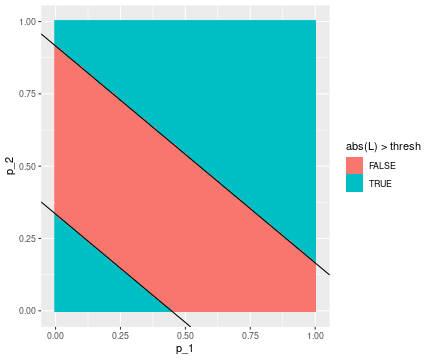

RObject{VecSxp}


In [212]:
R"""
df %>% 
    ggplot() + 
    geom_raster(aes(x = p_1, y = p_2, fill = abs(L) > thresh)) + 
    geom_abline(aes(slope = a, intercept = b)) + 
    geom_abline(aes(slope = a, intercept = b_))
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   ARI = col_double(),
│   EV = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


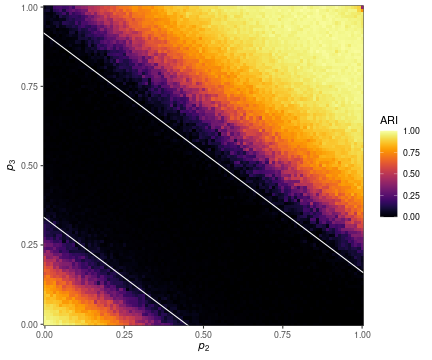

RObject{VecSxp}


In [213]:
ℓ = 2
q = 1/ℓ

k₁ = 2
k₂ = 3

C₁ = 5
C₂ = 5

title = "list(italic(c)[$k₁]==$C₁, italic(c)[$k₂]==$C₂, 'Alg. 1') "

R"""
library(tidyverse)
library(viridis)

df <- read_csv("throughput/vanilla-heatmap.csv")

df <- df %>%
    group_by(P_2, P_3, EV) %>% 
    summarise(ARI = mean(ARI, na.rm = T))

r <- df %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = ARI) + 
    geom_tile() + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1), na.value = "black") + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[3])) + 
    theme(panel.grid = element_blank(), 
    panel.spacing = unit(2, "lines"),
    strip.background = element_blank(),
    panel.spacing.x = unit(8, "mm"),
    strip.text = element_text(size = 10)) + 
    coord_fixed() + 
    guides(fill = guide_colorbar(title = "ARI")) + 
    geom_abline(aes(slope = a, intercept = b), color = "white") + 
    geom_abline(aes(slope = a, intercept = b_), color = "white") 
# + 
#    ggtitle(parse(text = $title))
    
r +     
    annotate(geom = "text", x = 0.9, y = 0.07, label = "?", hjust = "left", color = "white", size = 10) + 
    annotate(geom = "text", x = 0.02, y = 0.85, label = "?", hjust = "left", color = "white", size = 10) 

ggsave("fig/vanilla-heatmap.png", r,  width = 5, height = 4)
r
"""

In [216]:
R"""

r + ggtitle("(a).") + 
    p1 + ggtitle("(b).") + 
    p3 + ggtitle("(c).") + 
    p4 + ggtitle("(d).") + 
    plot_layout(guides = 'collect') 

ggsave("fig/4-heatmaps-1.png", dpi = 300, height = 7, width = 8)
"""



┌ Warning: RCall.jl: Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
│ Warning: Removed 315 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL
